In [ ]:
!pip install imbalanced-learn joblib
!pip install --upgrade gspread oauth2client


In [3]:
from google.colab import drive

def check_and_mount_drive():
    try:
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        print(f"Error mounting drive: {e}")

check_and_mount_drive()


Mounted at /content/drive


# *Data preprocessing*

In [ ]:
import os
import pandas as pd
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to process data in chunks
def process_data_in_chunks(attack, chunk_size=100000):
    dataset_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
    labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")

    chunk_list = []
    label_list = []

    try:
        # Read and process data in chunks
        for chunk in pd.read_csv(dataset_path, header=None, chunksize=chunk_size):
            chunk_list.append(chunk)

        data = pd.concat(chunk_list)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

       # Handle the Mirai Botnet dataset differently as it has no headers and an extra column in dataset file
        if attack == "Mirai Botnet":
            data = data.iloc[:, 1:]  # Drop the first column
            labels.columns = ["label"]
        else:
            labels.columns = ["index", "label"]  # Add headers
            labels = labels.drop(columns=["index"])  # Drop the serial number column

        # Ensure the dataset has 115 columns
        if data.shape[1] != 115:
            print(f"Error: Dataset for {attack} has incorrect number of columns: {data.shape[1]}")
            return False

        # Ensure the number of samples match
        if len(data) != len(labels):
            print(f"Error: Inconsistent number of samples in data and labels for {attack}")
            return False

        # Show first few rows of data and labels
        print("Data sample:")
        print(data.head())
        print("Labels sample:")
        print(labels.head())

        print(f"Preprocessed data for {attack}.")
        return True

    except Exception as e:
        print(f"Error processing {attack}: {e}")
        return False

# Preprocess each attack type
for i, attack in enumerate(attack_types):
    print(f"Processing {attack}...")

    # Remount drive every 1 iteration to avoid disconnection issues
    remount_drive()

    retry_count = 0
    max_retries = 5

    while retry_count < max_retries:
        if process_data_in_chunks(attack):
            break  # Break the loop if processing is successful
        else:
            retry_count += 1
            if retry_count < max_retries:
                print(f"Retrying {attack}... (Attempt {retry_count}/{max_retries})")
                remount_drive()
            else:
                print(f"Failed to process {attack} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Preprocessing completed for all attack types.")


Mounted at /content/drive
Processing Video Injection...
Mounted at /content/drive
Data sample:
        0            1              2         3            4              5    \
0  1.000000   209.000000       0.000000  1.000000   209.000000       0.000000   
1  1.995812   862.869190  425754.375319  1.997485   862.321515  425755.575114   
2  2.995771  1080.219198  377918.162404  2.997460  1079.731725  378131.164377   
3  3.993519  1188.840391  318604.518616  3.996108  1188.404523  318889.682843   
4  4.991995  1253.976598  271718.370035  4.995193  1253.586282  272024.597155   

        6            7              8         9    ...            105  106  \
0  1.000000   209.000000       0.000000  1.000000  ...       0.000000  0.0   
1  1.999161   861.773838  425756.175013  1.999916  ...  425756.249250  0.0   
2  2.999153  1079.243977  378343.810605  2.999915  ...  378439.385077  0.0   
3  3.998702  1187.968270  319174.718360  3.999870  ...  319302.942051  0.0   
4  4.998396  1253.195535  27

# *Model Training*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Function to train the model
def train_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers and extra unnamed index column in dataset file
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(f"Data scaled.")

        # Train model
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf_classifier.fit(X_train, y_train)
        print(f"Model trained.")

        # Save model and scaler
        model_dir = os.path.join(base_path, "models")
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(rf_classifier, os.path.join(model_dir, f"{attack}_rf_model_{frac}_{n_estimators}.joblib"))
        joblib.dump(scaler, os.path.join(model_dir, f"{attack}_scaler_{frac}_{n_estimators}.joblib"))
        print(f"Saved trained model and scaler for {attack} with frac={frac} and n_estimators={n_estimators}.")

    except Exception as e:
        print(f"Error training {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Training models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]

for i, attack in enumerate(attack_types):
    for frac in fractions:
        for n_estimators in estimators:
            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try:
                    # Remount drive every 2 iterations to avoid disconnection issues
                    if i % 2 == 0:
                        remount_drive()

                    print(f"Training {attack} with frac={frac} and n_estimators={n_estimators}...")
                    train_model(attack, frac, n_estimators)
                    break  # Break the loop if processing is successful
                except Exception as e:
                    print(f"Error: {e}")
                    retry_count += 1
                    if retry_count < max_retries:
                        print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                        remount_drive()
                    else:
                        print(f"Failed to train {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Training completed for all attack types.")


Mounted at /content/drive
Mounted at /content/drive
Training Video Injection with frac=0.1 and n_estimators=30...
Data split: X_train: (173068, 115), X_test: (74172, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.1 and n_estimators=30.
Mounted at /content/drive
Training Video Injection with frac=0.1 and n_estimators=50...
Data split: X_train: (173068, 115), X_test: (74172, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.1 and n_estimators=50.
Mounted at /content/drive
Training Video Injection with frac=0.1 and n_estimators=100...
Data split: X_train: (173068, 115), X_test: (74172, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.1 and n_estimators=100.
Mounted at /content/drive
Training Video Injection with frac=0.25 and n_estimators=30...
Data split: X_train: (432670, 115), X_test: (185430, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.25 and n_estimators=30.
Mounted at /content/drive
Training Video Injection with frac=0.25 and n_estimators=50...
Data split: X_train: (432670, 115), X_test: (185430, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.25 and n_estimators=50.
Mounted at /content/drive
Training Video Injection with frac=0.25 and n_estimators=100...
Data split: X_train: (432670, 115), X_test: (185430, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.25 and n_estimators=100.
Mounted at /content/drive
Training Video Injection with frac=0.5 and n_estimators=30...
Data split: X_train: (865340, 115), X_test: (370860, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.5 and n_estimators=30.
Mounted at /content/drive
Training Video Injection with frac=0.5 and n_estimators=50...
Data split: X_train: (865340, 115), X_test: (370860, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.5 and n_estimators=50.
Mounted at /content/drive
Training Video Injection with frac=0.5 and n_estimators=100...
Data split: X_train: (865340, 115), X_test: (370860, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.5 and n_estimators=100.
Mounted at /content/drive
Training Video Injection with frac=0.75 and n_estimators=30...
Data split: X_train: (1298010, 115), X_test: (556291, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.75 and n_estimators=30.
Mounted at /content/drive
Training Video Injection with frac=0.75 and n_estimators=50...
Data split: X_train: (1298010, 115), X_test: (556291, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.75 and n_estimators=50.
Mounted at /content/drive
Training Video Injection with frac=0.75 and n_estimators=100...
Data split: X_train: (1298010, 115), X_test: (556291, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=0.75 and n_estimators=100.
Mounted at /content/drive
Training Video Injection with frac=1.0 and n_estimators=30...
Data split: X_train: (1730680, 115), X_test: (741721, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=1.0 and n_estimators=30.
Mounted at /content/drive
Training Video Injection with frac=1.0 and n_estimators=50...
Data split: X_train: (1730680, 115), X_test: (741721, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=1.0 and n_estimators=50.
Mounted at /content/drive
Training Video Injection with frac=1.0 and n_estimators=100...
Data split: X_train: (1730680, 115), X_test: (741721, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Video Injection with frac=1.0 and n_estimators=100.
Training OS Scan with frac=0.1 and n_estimators=30...
Data split: X_train: (118849, 115), X_test: (50936, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.1 and n_estimators=30.
Training OS Scan with frac=0.1 and n_estimators=50...
Data split: X_train: (118849, 115), X_test: (50936, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.1 and n_estimators=50.
Training OS Scan with frac=0.1 and n_estimators=100...
Data split: X_train: (118849, 115), X_test: (50936, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.1 and n_estimators=100.
Training OS Scan with frac=0.25 and n_estimators=30...
Data split: X_train: (297124, 115), X_test: (127339, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.25 and n_estimators=30.
Training OS Scan with frac=0.25 and n_estimators=50...
Data split: X_train: (297124, 115), X_test: (127339, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.25 and n_estimators=50.
Training OS Scan with frac=0.25 and n_estimators=100...
Data split: X_train: (297124, 115), X_test: (127339, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.25 and n_estimators=100.
Training OS Scan with frac=0.5 and n_estimators=30...
Data split: X_train: (594248, 115), X_test: (254678, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.5 and n_estimators=30.
Training OS Scan with frac=0.5 and n_estimators=50...
Data split: X_train: (594248, 115), X_test: (254678, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.5 and n_estimators=50.
Training OS Scan with frac=0.5 and n_estimators=100...
Data split: X_train: (594248, 115), X_test: (254678, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.5 and n_estimators=100.
Training OS Scan with frac=0.75 and n_estimators=30...
Data split: X_train: (891371, 115), X_test: (382017, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.75 and n_estimators=30.
Training OS Scan with frac=0.75 and n_estimators=50...
Data split: X_train: (891371, 115), X_test: (382017, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.75 and n_estimators=50.
Training OS Scan with frac=0.75 and n_estimators=100...
Data split: X_train: (891371, 115), X_test: (382017, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=0.75 and n_estimators=100.
Training OS Scan with frac=1.0 and n_estimators=30...
Data split: X_train: (1188495, 115), X_test: (509356, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=1.0 and n_estimators=30.
Training OS Scan with frac=1.0 and n_estimators=50...
Data split: X_train: (1188495, 115), X_test: (509356, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=1.0 and n_estimators=50.
Training OS Scan with frac=1.0 and n_estimators=100...
Data split: X_train: (1188495, 115), X_test: (509356, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for OS Scan with frac=1.0 and n_estimators=100.
Mounted at /content/drive
Training Fuzzing with frac=0.1 and n_estimators=30...
Data split: X_train: (157089, 115), X_test: (67325, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.1 and n_estimators=30.
Mounted at /content/drive
Training Fuzzing with frac=0.1 and n_estimators=50...
Data split: X_train: (157089, 115), X_test: (67325, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.1 and n_estimators=50.
Mounted at /content/drive
Training Fuzzing with frac=0.1 and n_estimators=100...
Data split: X_train: (157089, 115), X_test: (67325, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.1 and n_estimators=100.
Mounted at /content/drive
Training Fuzzing with frac=0.25 and n_estimators=30...
Data split: X_train: (392724, 115), X_test: (168311, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.25 and n_estimators=30.
Mounted at /content/drive
Training Fuzzing with frac=0.25 and n_estimators=50...
Data split: X_train: (392724, 115), X_test: (168311, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.25 and n_estimators=50.
Mounted at /content/drive
Training Fuzzing with frac=0.25 and n_estimators=100...
Data split: X_train: (392724, 115), X_test: (168311, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.25 and n_estimators=100.
Mounted at /content/drive
Training Fuzzing with frac=0.5 and n_estimators=30...
Data split: X_train: (785449, 115), X_test: (336621, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.5 and n_estimators=30.
Mounted at /content/drive
Training Fuzzing with frac=0.5 and n_estimators=50...
Data split: X_train: (785449, 115), X_test: (336621, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.5 and n_estimators=50.
Mounted at /content/drive
Training Fuzzing with frac=0.5 and n_estimators=100...
Data split: X_train: (785449, 115), X_test: (336621, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.5 and n_estimators=100.
Mounted at /content/drive
Training Fuzzing with frac=0.75 and n_estimators=30...
Data split: X_train: (1178172, 115), X_test: (504932, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.75 and n_estimators=30.
Mounted at /content/drive
Training Fuzzing with frac=0.75 and n_estimators=50...
Data split: X_train: (1178172, 115), X_test: (504932, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.75 and n_estimators=50.
Mounted at /content/drive
Training Fuzzing with frac=0.75 and n_estimators=100...
Data split: X_train: (1178172, 115), X_test: (504932, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=0.75 and n_estimators=100.
Mounted at /content/drive
Training Fuzzing with frac=1.0 and n_estimators=30...
Data split: X_train: (1570897, 115), X_test: (673242, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=1.0 and n_estimators=30.
Mounted at /content/drive
Training Fuzzing with frac=1.0 and n_estimators=50...
Data split: X_train: (1570897, 115), X_test: (673242, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=1.0 and n_estimators=50.
Mounted at /content/drive
Training Fuzzing with frac=1.0 and n_estimators=100...
Data split: X_train: (1570897, 115), X_test: (673242, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Fuzzing with frac=1.0 and n_estimators=100.
Training ARP MitM with frac=0.1 and n_estimators=30...
Data split: X_train: (175298, 115), X_test: (75129, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.1 and n_estimators=30.
Training ARP MitM with frac=0.1 and n_estimators=50...
Data split: X_train: (175298, 115), X_test: (75129, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.1 and n_estimators=50.
Training ARP MitM with frac=0.1 and n_estimators=100...
Data split: X_train: (175298, 115), X_test: (75129, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.1 and n_estimators=100.
Training ARP MitM with frac=0.25 and n_estimators=30...
Data split: X_train: (438246, 115), X_test: (187821, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.25 and n_estimators=30.
Training ARP MitM with frac=0.25 and n_estimators=50...
Data split: X_train: (438246, 115), X_test: (187821, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.25 and n_estimators=50.
Training ARP MitM with frac=0.25 and n_estimators=100...
Data split: X_train: (438246, 115), X_test: (187821, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.25 and n_estimators=100.
Training ARP MitM with frac=0.5 and n_estimators=30...
Data split: X_train: (876493, 115), X_test: (375641, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.5 and n_estimators=30.
Training ARP MitM with frac=0.5 and n_estimators=50...
Data split: X_train: (876493, 115), X_test: (375641, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.5 and n_estimators=50.
Training ARP MitM with frac=0.5 and n_estimators=100...
Data split: X_train: (876493, 115), X_test: (375641, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.5 and n_estimators=100.
Training ARP MitM with frac=0.75 and n_estimators=30...
Data split: X_train: (1314740, 115), X_test: (563460, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.75 and n_estimators=30.
Training ARP MitM with frac=0.75 and n_estimators=50...
Data split: X_train: (1314740, 115), X_test: (563460, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.75 and n_estimators=50.
Training ARP MitM with frac=0.75 and n_estimators=100...
Data split: X_train: (1314740, 115), X_test: (563460, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=0.75 and n_estimators=100.
Training ARP MitM with frac=1.0 and n_estimators=30...
Data split: X_train: (1752986, 115), X_test: (751281, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=1.0 and n_estimators=30.
Training ARP MitM with frac=1.0 and n_estimators=50...
Data split: X_train: (1752986, 115), X_test: (751281, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=1.0 and n_estimators=50.
Training ARP MitM with frac=1.0 and n_estimators=100...
Data split: X_train: (1752986, 115), X_test: (751281, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for ARP MitM with frac=1.0 and n_estimators=100.
Mounted at /content/drive
Training Active Wiretap with frac=0.1 and n_estimators=30...
Data split: X_train: (159508, 115), X_test: (68361, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.1 and n_estimators=30.
Mounted at /content/drive
Training Active Wiretap with frac=0.1 and n_estimators=50...
Data split: X_train: (159508, 115), X_test: (68361, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.1 and n_estimators=50.
Mounted at /content/drive
Training Active Wiretap with frac=0.1 and n_estimators=100...
Data split: X_train: (159508, 115), X_test: (68361, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.1 and n_estimators=100.
Mounted at /content/drive
Training Active Wiretap with frac=0.25 and n_estimators=30...
Data split: X_train: (398770, 115), X_test: (170902, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.25 and n_estimators=30.
Mounted at /content/drive
Training Active Wiretap with frac=0.25 and n_estimators=50...
Data split: X_train: (398770, 115), X_test: (170902, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.25 and n_estimators=50.
Mounted at /content/drive
Training Active Wiretap with frac=0.25 and n_estimators=100...
Data split: X_train: (398770, 115), X_test: (170902, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.25 and n_estimators=100.
Mounted at /content/drive
Training Active Wiretap with frac=0.5 and n_estimators=30...
Data split: X_train: (797540, 115), X_test: (341804, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.5 and n_estimators=30.
Mounted at /content/drive
Training Active Wiretap with frac=0.5 and n_estimators=50...
Data split: X_train: (797540, 115), X_test: (341804, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.5 and n_estimators=50.
Mounted at /content/drive
Training Active Wiretap with frac=0.5 and n_estimators=100...
Data split: X_train: (797540, 115), X_test: (341804, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.5 and n_estimators=100.
Mounted at /content/drive
Training Active Wiretap with frac=0.75 and n_estimators=30...
Data split: X_train: (1196311, 115), X_test: (512706, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.75 and n_estimators=30.
Mounted at /content/drive
Training Active Wiretap with frac=0.75 and n_estimators=50...
Data split: X_train: (1196311, 115), X_test: (512706, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.75 and n_estimators=50.
Mounted at /content/drive
Training Active Wiretap with frac=0.75 and n_estimators=100...
Data split: X_train: (1196311, 115), X_test: (512706, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=0.75 and n_estimators=100.
Mounted at /content/drive
Training Active Wiretap with frac=1.0 and n_estimators=30...
Data split: X_train: (1595082, 115), X_test: (683607, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=1.0 and n_estimators=30.
Mounted at /content/drive
Training Active Wiretap with frac=1.0 and n_estimators=50...
Data split: X_train: (1595082, 115), X_test: (683607, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=1.0 and n_estimators=50.
Mounted at /content/drive
Training Active Wiretap with frac=1.0 and n_estimators=100...
Data split: X_train: (1595082, 115), X_test: (683607, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for Active Wiretap with frac=1.0 and n_estimators=100.
Training SSDP Flood with frac=0.1 and n_estimators=30...
Data split: X_train: (285408, 115), X_test: (122319, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.1 and n_estimators=30.
Training SSDP Flood with frac=0.1 and n_estimators=50...
Data split: X_train: (285408, 115), X_test: (122319, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.1 and n_estimators=50.
Training SSDP Flood with frac=0.1 and n_estimators=100...
Data split: X_train: (285408, 115), X_test: (122319, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.1 and n_estimators=100.
Training SSDP Flood with frac=0.25 and n_estimators=30...
Data split: X_train: (713521, 115), X_test: (305795, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.25 and n_estimators=30.
Training SSDP Flood with frac=0.25 and n_estimators=50...
Data split: X_train: (713521, 115), X_test: (305795, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.25 and n_estimators=50.
Training SSDP Flood with frac=0.25 and n_estimators=100...
Data split: X_train: (713521, 115), X_test: (305795, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.25 and n_estimators=100.
Training SSDP Flood with frac=0.5 and n_estimators=30...
Data split: X_train: (1427043, 115), X_test: (611590, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.5 and n_estimators=30.
Training SSDP Flood with frac=0.5 and n_estimators=50...
Data split: X_train: (1427043, 115), X_test: (611590, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.5 and n_estimators=50.
Training SSDP Flood with frac=0.5 and n_estimators=100...
Data split: X_train: (1427043, 115), X_test: (611590, 115)
Data scaled.


<ipython-input-4-aa3136cf4b69>:54: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.5 and n_estimators=100.
Training SSDP Flood with frac=0.75 and n_estimators=30...


*continuation...*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to train the model
def train_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Skip if model already exists
        if os.path.exists(model_path) and os.path.exists(scaler_path):
            print(f"Model and scaler for {attack} with frac={frac} and n_estimators={n_estimators} already exist. Skipping...")
            return

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(f"Data scaled.")

        # Train model
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf_classifier.fit(X_train, y_train.values.ravel())
        print(f"Model trained.")

        # Save model and scaler
        os.makedirs(os.path.join(base_path, "models"), exist_ok=True)
        joblib.dump(rf_classifier, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Saved trained model and scaler for {attack} with frac={frac} and n_estimators={n_estimators}.")

    except Exception as e:
        print(f"Error training {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Training models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]

resume = False

for i, attack in enumerate(attack_types):
    for frac in fractions:
        for n_estimators in estimators:
            if attack == "SSDP Flood" and frac == 0.75 and n_estimators == 30:
                resume = True  # Start resuming from this point
            if resume:
                retry_count = 0
                max_retries = 5
                while retry_count < max_retries:
                    try:
                        # Remount drive every 2 iterations to avoid disconnection issues
                        if i % 2 == 0:
                            remount_drive()

                        print(f"Training {attack} with frac={frac} and n_estimators={n_estimators}...")
                        train_model(attack, frac, n_estimators)
                        break  # Break the loop if processing is successful
                    except Exception as e:
                        print(f"Error: {e}")
                        retry_count += 1
                        if retry_count < max_retries:
                            print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                            remount_drive()
                        else:
                            print(f"Failed to train {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Training completed for all attack types.")


Mounted at /content/drive
Training SSDP Flood with frac=0.75 and n_estimators=30...
Data split: X_train: (2140565, 115), X_test: (917385, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.75 and n_estimators=30.
Training SSDP Flood with frac=0.75 and n_estimators=50...
Data split: X_train: (2140565, 115), X_test: (917385, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.75 and n_estimators=50.
Training SSDP Flood with frac=0.75 and n_estimators=100...
Data split: X_train: (2140565, 115), X_test: (917385, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SSDP Flood with frac=0.75 and n_estimators=100.
Training SSDP Flood with frac=1.0 and n_estimators=30...
Data split: X_train: (2854086, 115), X_test: (1223180, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SSDP Flood with frac=1.0 and n_estimators=30.
Training SSDP Flood with frac=1.0 and n_estimators=50...
Data spl

*continuation...*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to train the model
def train_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Skip if model already exists
        if os.path.exists(model_path) and os.path.exists(scaler_path):
            print(f"Model and scaler for {attack} with frac={frac} and n_estimators={n_estimators} already exist. Skipping...")
            return

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(f"Data scaled.")

        # Train model
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf_classifier.fit(X_train, y_train.values.ravel())
        print(f"Model trained.")

        # Save model and scaler
        os.makedirs(os.path.join(base_path, "models"), exist_ok=True)
        joblib.dump(rf_classifier, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Saved trained model and scaler for {attack} with frac={frac} and n_estimators={n_estimators}.")

    except Exception as e:
        print(f"Error training {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Training models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]

resume = False

for i, attack in enumerate(attack_types):
    for frac in fractions:
        for n_estimators in estimators:
            if attack == "SYN DoS" and frac == 0.25 and n_estimators == 50:
                resume = True  # Start resuming from this point
            if resume:
                retry_count = 0
                max_retries = 5
                while retry_count < max_retries:
                    try:
                        # Remount drive every 2 iterations to avoid disconnection issues
                        if i % 2 == 0:
                            remount_drive()

                        print(f"Training {attack} with frac={frac} and n_estimators={n_estimators}...")
                        train_model(attack, frac, n_estimators)
                        break  # Break the loop if processing is successful
                    except Exception as e:
                        print(f"Error: {e}")
                        retry_count += 1
                        if retry_count < max_retries:
                            print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                            remount_drive()
                        else:
                            print(f"Failed to train {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Training completed for all attack types.")


Mounted at /content/drive
Mounted at /content/drive
Training SYN DoS with frac=0.25 and n_estimators=50...
Data split: X_train: (484973, 115), X_test: (207846, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SYN DoS with frac=0.25 and n_estimators=50.
Mounted at /content/drive
Training SYN DoS with frac=0.25 and n_estimators=100...
Data split: X_train: (484973, 115), X_test: (207846, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SYN DoS with frac=0.25 and n_estimators=100.
Mounted at /content/drive
Training SYN DoS with frac=0.5 and n_estimators=30...
Data split: X_train: (969946, 115), X_test: (415692, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SYN DoS with frac=0.5 and n_estimators=30.
Mounted at /content/drive
Training SYN DoS with frac=0.5 and n_estimators=50...
Data split: X_train: (969946, 115), X_test: (415692, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SYN DoS with frac=0.5 and n_estimat

*continuation...*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to train the model
def train_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Skip if model already exists
        if os.path.exists(model_path) and os.path.exists(scaler_path):
            print(f"Model and scaler for {attack} with frac={frac} and n_estimators={n_estimators} already exist. Skipping...")
            return

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(f"Data scaled.")

        # Train model
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf_classifier.fit(X_train, y_train.values.ravel())
        print(f"Model trained.")

        # Save model and scaler
        os.makedirs(os.path.join(base_path, "models"), exist_ok=True)
        joblib.dump(rf_classifier, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Saved trained model and scaler for {attack} with frac={frac} and n_estimators={n_estimators}.")

    except Exception as e:
        print(f"Error training {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Training models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]

resume = False

for i, attack in enumerate(attack_types):
    for frac in fractions:
        for n_estimators in estimators:
            if attack == "SYN DoS" and frac == 1.0 and n_estimators == 30:
                resume = True  # Start resuming from this point
            if resume:
                retry_count = 0
                max_retries = 5
                while retry_count < max_retries:
                    try:
                        # Remount drive every 2 iterations to avoid disconnection issues
                        if i % 2 == 0:
                            remount_drive()

                        print(f"Training {attack} with frac={frac} and n_estimators={n_estimators}...")
                        train_model(attack, frac, n_estimators)
                        break  # Break the loop if processing is successful
                    except Exception as e:
                        print(f"Error: {e}")
                        retry_count += 1
                        if retry_count < max_retries:
                            print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                            remount_drive()
                        else:
                            print(f"Failed to train {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Training completed for all attack types.")


Mounted at /content/drive
Mounted at /content/drive
Training SYN DoS with frac=1.0 and n_estimators=30...
Data split: X_train: (1939893, 115), X_test: (831383, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SYN DoS with frac=1.0 and n_estimators=30.
Mounted at /content/drive
Training SYN DoS with frac=1.0 and n_estimators=50...
Data split: X_train: (1939893, 115), X_test: (831383, 115)


In [ ]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to train the model
def train_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Skip if model already exists
        if os.path.exists(model_path) and os.path.exists(scaler_path):
            print(f"Model and scaler for {attack} with frac={frac} and n_estimators={n_estimators} already exist. Skipping...")
            return

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        print(f"Data scaled.")

        # Train model
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf_classifier.fit(X_train, y_train.values.ravel())
        print(f"Model trained.")

        # Save model and scaler
        os.makedirs(os.path.join(base_path, "models"), exist_ok=True)
        joblib.dump(rf_classifier, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Saved trained model and scaler for {attack} with frac={frac} and n_estimators={n_estimators}.")

    except Exception as e:
        print(f"Error training {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Training models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]

resume = False

for i, attack in enumerate(attack_types):
    for frac in fractions:
        for n_estimators in estimators:
            if attack == "SYN DoS" and frac == 1.0 and n_estimators == 30:
                resume = True  # Start resuming from this point
            if resume:
                retry_count = 0
                max_retries = 5
                while retry_count < max_retries:
                    try:
                        # Remount drive every 2 iterations to avoid disconnection issues
                        if i % 2 == 0:
                            remount_drive()

                        print(f"Training {attack} with frac={frac} and n_estimators={n_estimators}...")
                        train_model(attack, frac, n_estimators)
                        break  # Break the loop if processing is successful
                    except Exception as e:
                        print(f"Error: {e}")
                        retry_count += 1
                        if retry_count < max_retries:
                            print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                            remount_drive()
                        else:
                            print(f"Failed to train {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Training completed for all attack types.")


Mounted at /content/drive
Mounted at /content/drive
Training SYN DoS with frac=1.0 and n_estimators=30...
Model and scaler for SYN DoS with frac=1.0 and n_estimators=30 already exist. Skipping...
Mounted at /content/drive
Training SYN DoS with frac=1.0 and n_estimators=50...
Model and scaler for SYN DoS with frac=1.0 and n_estimators=50 already exist. Skipping...
Mounted at /content/drive
Training SYN DoS with frac=1.0 and n_estimators=100...
Data split: X_train: (1939893, 115), X_test: (831383, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SYN DoS with frac=1.0 and n_estimators=100.
Training SSL Renegotiation with frac=0.1 and n_estimators=30...
Data split: X_train: (154529, 115), X_test: (66228, 115)
Data scaled.
Model trained.
Saved trained model and scaler for SSL Renegotiation with frac=0.1 and n_estimators=30.
Training SSL Renegotiation with frac=0.1 and n_estimators=50...
Data split: X_train: (154529, 115), X_test: (66228, 115)
Data scaled.
Model trained.
S

# *Model Evaluation*

*Confusion Matrix, ROC , Feature Importance*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Function to evaluate the model
def evaluate_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Scale data
        X_test = scaler.transform(X_test)
        print(f"Data scaled for evaluation.")

        # Evaluate model
        y_pred = rf_classifier.predict(X_test)
        y_proba = rf_classifier.predict_proba(X_test)[:, 1]

        # Calculate metrics
        print(f"Random Forest Accuracy for {attack} with frac={frac} and n_estimators={n_estimators}: {rf_classifier.score(X_test, y_test)}")
        print(f"Random Forest Classification Report for {attack} with frac={frac} and n_estimators={n_estimators}:\n{classification_report(y_test, y_pred)}")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malicious'], yticklabels=['benign', 'malicious'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {attack} with frac={frac} and n_estimators={n_estimators}")
        plt.show()

        # Extract TP, TN, FP, FN from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {attack} with frac={frac} and n_estimators={n_estimators}')
        plt.legend(loc="lower right")
        plt.show()

        # Feature Importance
        feature_importances = rf_classifier.feature_importances_
        sorted_idx = feature_importances.argsort()[-10:][::-1]
        top_features = pd.DataFrame({
            'Feature': [f'feature_{i+1}' for i in sorted_idx],
            'Importance': feature_importances[sorted_idx]
        })

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top 10 Features Importance for {attack} with frac={frac} and n_estimators={n_estimators}')
        plt.show()

        print(f"Top 10 Features for {attack} with frac={frac} and n_estimators={n_estimators}:\n{top_features}")

    except Exception as e:
        print(f"Error evaluating {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Evaluate models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]

for i, attack in enumerate(attack_types):
    for frac in fractions:
        for n_estimators in estimators:
            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try:
                    # Remount drive every 2 iterations to avoid disconnection issues
                    if i % 2 == 0:
                        remount_drive()

                    print(f"Evaluating {attack} with frac={frac} and n_estimators={n_estimators}...")
                    evaluate_model(attack, frac, n_estimators)
                    break  # Break the loop if processing is successful
                except Exception as e:
                    print(f"Error: {e}")
                    retry_count += 1
                    if retry_count < max_retries:
                        print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                        remount_drive()
                    else:
                        print(f"Failed to evaluate {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

print("\n" + "="*50 + "\n")
print("Evaluation completed for all attack types.")


Output hidden; open in https://colab.research.google.com to view.

*continuation...*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import time
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Function to evaluate the model and save the ROC plot
def evaluate_model(attack, frac, n_estimators, save_path):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Scale data
        X_test = scaler.transform(X_test)
        print(f"Data scaled for evaluation.")

        # Evaluate model
        y_pred = rf_classifier.predict(X_test)
        y_proba = rf_classifier.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = rf_classifier.score(X_test, y_test)
        print(f"Random Forest Accuracy for {attack} with frac={frac} and n_estimators={n_estimators}: {accuracy}")
        print(f"Random Forest Classification Report for {attack} with frac={frac} and n_estimators={n_estimators}:\n{classification_report(y_test, y_pred)}")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malicious'], yticklabels=['benign', 'malicious'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {attack} with frac={frac} and n_estimators={n_estimators}")
        plt.show()

        # Extract TP, TN, FP, FN from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {attack} with frac={frac} and n_estimators={n_estimators}')
        plt.legend(loc="lower right")

        # Save the ROC plot
        roc_image_path = os.path.join(save_path, f"roc_{attack.replace(' ', '_')}_frac_{frac}_n_{n_estimators}.png")
        plt.savefig(roc_image_path)
        plt.close()

        # Return accuracy and confusion matrix metrics for summary plot
        return roc_image_path, accuracy, tp, tn, fp, fn

    except Exception as e:
        print(f"Error evaluating {attack} with frac={frac} and n_estimators={n_estimators}: {e}")
        return None, None, None, None, None, None

# Evaluate models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Directory to save ROC plots
save_dir = '/content/drive/MyDrive/kitsune/roc_plots'
os.makedirs(save_dir, exist_ok=True)

# Lists to store paths of saved ROC images and accuracy values
roc_image_paths = []
metrics_values = []

for attack in attack_types:
    for frac in fractions:
        for n_estimators in estimators:
            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try:
                    # Remount drive every 2 iterations to avoid disconnection issues
                    if (retry_count + frac * len(estimators) + n_estimators) % 2 == 0:
                        remount_drive()

                    print(f"Evaluating {attack} with frac={frac} and n_estimators={n_estimators}...")
                    roc_image_path, accuracy, tp, tn, fp, fn = evaluate_model(attack, frac, n_estimators, save_dir)
                    if roc_image_path:
                        roc_image_paths.append((attack, frac, n_estimators, roc_image_path))
                        metrics_values.append((attack, frac, n_estimators, accuracy, tp, tn, fp, fn))
                    break  # Break the loop if processing is successful
                except Exception as e:
                    print(f"Error: {e}")
                    retry_count += 1
                    if retry_count < max_retries:
                        print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                        remount_drive()
                    else:
                        print(f"Failed to evaluate {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

# Now, create a combined plot with ROC images for each attack
fig, axes = plt.subplots(len(attack_types), len(fractions), figsize=(len(fractions) * 5, len(attack_types) * 5))

for i, attack in enumerate(attack_types):
    for j, frac in enumerate(fractions):
        for k, n_estimators in enumerate(estimators):
            image_path = next((path for a, f, n, path in roc_image_paths if a == attack and f == frac and n == n_estimators), None)
            if image_path:
                img = mpimg.imread(image_path)
                ax = axes[i, j]
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"{attack} - frac={frac} - n={n_estimators}")

plt.tight_layout()
plt.show()

# Create a DataFrame from metrics_values
metrics_df = pd.DataFrame(metrics_values, columns=['Attack', 'Fraction', 'Estimators', 'Accuracy', 'TP', 'TN', 'FP', 'FN'])

# Plot TP, FP, TN, FN for all attacks
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# True Positives
sns.lineplot(data=metrics_df, x='Fraction', y='TP', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[0, 0])
axes[0, 0].set_title('True Positives for All Attacks')
axes[0, 0].set_xlabel('Data Fraction')
axes[0, 0].set_ylabel('True Positives')

# False Positives
sns.lineplot(data=metrics_df, x='Fraction', y='FP', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[0, 1])
axes[0, 1].set_title('False Positives for All Attacks')
axes[0, 1].set_xlabel('Data Fraction')
axes[0, 1].set_ylabel('False Positives')

# True Negatives
sns.lineplot(data=metrics_df, x='Fraction', y='TN', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[1, 0])
axes[1, 0].set_title('True Negatives for All Attacks')
axes[1, 0].set_xlabel('Data Fraction')
axes[1, 0].set_ylabel('True Negatives')

# False Negatives
sns.lineplot(data=metrics_df, x='Fraction', y='FN', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[1, 1])
axes[1, 1].set_title('False Negatives for All Attacks')
axes[1, 1].set_xlabel('Data Fraction')
axes[1, 1].set_ylabel('False Negatives')

# Adjust layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Output hidden; open in https://colab.research.google.com to view.

*continuation...*

In [ ]:

import os
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import time
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import csv

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'
log_file_path = os.path.join(base_path, 'evaluation_log.csv')

# Function to log completed evaluations
def log_completed_evaluation(attack, frac, n_estimators):
    with open(log_file_path, 'a') as log_file:
        log_writer = csv.writer(log_file)
        log_writer.writerow([attack, frac, n_estimators])

# Function to check if an evaluation is already completed
def is_evaluation_completed(attack, frac, n_estimators):
    if not os.path.exists(log_file_path):
        return False
    with open(log_file_path, 'r') as log_file:
        log_reader = csv.reader(log_file)
        for row in log_reader:
            if row == [attack, str(frac), str(n_estimators)]:
                return True
    return False

# Function to evaluate the model and save the ROC plot
def evaluate_model(attack, frac, n_estimators, save_path):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        print(f"Loading data for {attack} with frac={frac} and n_estimators={n_estimators} from {data_path} and {labels_path}...")
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        print("Data and labels loaded successfully.")

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        print(f"Data sampled: {data_sample.shape}, Labels sampled: {labels_sample.shape}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Scale data
        X_test = scaler.transform(X_test)
        print(f"Data scaled for evaluation.")

        # Evaluate model
        y_pred = rf_classifier.predict(X_test)
        y_proba = rf_classifier.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = rf_classifier.score(X_test, y_test)
        print(f"Random Forest Accuracy for {attack} with frac={frac} and n_estimators={n_estimators}: {accuracy}")
        print(f"Random Forest Classification Report for {attack} with frac={frac} and n_estimators={n_estimators}:\n{classification_report(y_test, y_pred)}")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malicious'], yticklabels=['benign', 'malicious'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {attack} with frac={frac} and n_estimators={n_estimators}")
        plt.show()

        # Extract TP, TN, FP, FN from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {attack} with frac={frac} and n_estimators={n_estimators}')
        plt.legend(loc="lower right")

        # Save the ROC plot
        roc_image_path = os.path.join(save_path, f"roc_{attack.replace(' ', '_')}_frac_{frac}_n_{n_estimators}.png")
        plt.savefig(roc_image_path)
        plt.close()

        # Log the completed evaluation
        log_completed_evaluation(attack, frac, n_estimators)

        # Return accuracy and confusion matrix metrics for summary plot
        return roc_image_path, accuracy, tp, tn, fp, fn

    except Exception as e:
        print(f"Error evaluating {attack} with frac={frac} and n_estimators={n_estimators}: {e}")
        return None, None, None, None, None, None

# Evaluate models with increasing data fraction and number of estimators
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
estimators = [30, 50, 100]
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Directory to save ROC plots
save_dir = '/content/drive/MyDrive/kitsune/roc_plots'
os.makedirs(save_dir, exist_ok=True)

# Lists to store paths of saved ROC images and accuracy values
roc_image_paths = []
metrics_values = []

resume = False

for attack in attack_types:
    for frac in fractions:
        for n_estimators in estimators:
            if attack == "SSDP Flood" and frac == 0.75 and n_estimators == 30:
                resume = True  # Start resuming from this point
            if resume:
                if not is_evaluation_completed(attack, frac, n_estimators):
                    retry_count = 0
                    max_retries = 5
                    while retry_count < max_retries:
                        try:
                            # Remount drive every 2 iterations to avoid disconnection issues
                            if (retry_count + frac * len(estimators) + n_estimators) % 2 == 0:
                                remount_drive()

                            print(f"Evaluating {attack} with frac={frac} and n_estimators={n_estimators}...")
                            roc_image_path, accuracy, tp, tn, fp, fn = evaluate_model(attack, frac, n_estimators, save_dir)
                            if roc_image_path:
                                roc_image_paths.append((attack, frac, n_estimators, roc_image_path))
                                metrics_values.append((attack, frac, n_estimators, accuracy, tp, tn, fp, fn))
                            break  # Break the loop if processing is successful
                        except Exception as e:
                            print(f"Error: {e}")
                            retry_count += 1
                            if retry_count < max_retries:
                                print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                                remount_drive()
                            else:
                                print(f"Failed to evaluate {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

# Now, create a combined plot with ROC images for each attack
fig, axes = plt.subplots(len(attack_types), len(fractions), figsize=(len(fractions) * 5, len(attack_types) * 5))

for i, attack in enumerate(attack_types):
    for j, frac in enumerate(fractions):
        for k, n_estimators in enumerate(estimators):
            image_path = next((path for a, f, n, path in roc_image_paths if a == attack and f == frac and n == n_estimators), None)
            if image_path:
                img = mpimg.imread(image_path)
                ax = axes[i, j]
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"{attack} - frac={frac} - n={n_estimators}")

plt.tight_layout()
plt.show()

# Create a DataFrame from metrics_values
metrics_df = pd.DataFrame(metrics_values, columns=['Attack', 'Fraction', 'Estimators', 'Accuracy', 'TP', 'TN', 'FP', 'FN'])

# Plot TP, FP, TN, FN for all attacks
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# True Positives
sns.lineplot(data=metrics_df, x='Fraction', y='TP', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[0, 0])
axes[0, 0].set_title('True Positives for All Attacks')
axes[0, 0].set_xlabel('Data Fraction')
axes[0, 0].set_ylabel('True Positives')

# False Positives
sns.lineplot(data=metrics_df, x='Fraction', y='FP', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[0, 1])
axes[0, 1].set_title('False Positives for All Attacks')
axes[0, 1].set_xlabel('Data Fraction')
axes[0, 1].set_ylabel('False Positives')

# True Negatives
sns.lineplot(data=metrics_df, x='Fraction', y='TN', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[1, 0])
axes[1, 0].set_title('True Negatives for All Attacks')
axes[1, 0].set_xlabel('Data Fraction')
axes[1, 0].set_ylabel('True Negatives')

# False Negatives
sns.lineplot(data=metrics_df, x='Fraction', y='FN', hue='Attack', style='Estimators', markers=True, dashes=False, ax=axes[1, 1])
axes[1, 1].set_title('False Negatives for All Attacks')
axes[1, 1].set_xlabel('Data Fraction')
axes[1, 1].set_ylabel('False Negatives')

# Adjust layout
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# *Saving Evaluation Metrics in CSV file*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Load existing metrics if available
metrics_path = os.path.join(base_path, 'evaluation_metrics.csv')
if os.path.exists(metrics_path):
    existing_metrics_df = pd.read_csv(metrics_path)
    existing_metrics = existing_metrics_df.to_dict('records')
else:
    existing_metrics = []

# Function to evaluate the model
def evaluate_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models ", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models ", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Scale data
        X_test = scaler.transform(X_test)
        print(f"Data scaled for evaluation.")

        # Evaluate model
        y_pred = rf_classifier.predict(X_test)
        y_proba = rf_classifier.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = rf_classifier.score(X_test, y_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

        # Extract TP, TN, FP, FN from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Feature Importance
        feature_importances = rf_classifier.feature_importances_
        sorted_idx = feature_importances.argsort()[-10:][::-1]
        top_features = pd.DataFrame({
            'Feature': [f'feature_{i+1}' for i in sorted_idx],
            'Importance': feature_importances[sorted_idx]
        })

        # Save metrics
        metrics = {
            'Attack': attack,
            'Fraction': frac,
            'Estimators': n_estimators,
            'Accuracy': accuracy,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'ROC AUC': roc_auc,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malicious'], yticklabels=['benign', 'malicious'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {attack} with frac={frac} and n_estimators={n_estimators}")
        conf_matrix_path = os.path.join(base_path, 'conf_matrices', f"{attack}_conf_matrix_{frac}_{n_estimators}.png")
        plt.savefig(conf_matrix_path)
        plt.close()

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {attack} with frac={frac} and n_estimators={n_estimators}')
        plt.legend(loc="lower right")
        roc_plot_path = os.path.join(base_path, 'roc_plots', f"{attack}_roc_curve_{frac}_{n_estimators}.png")
        plt.savefig(roc_plot_path)
        plt.close()

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top 10 Features Importance for {attack} with frac={frac} and n_estimators={n_estimators}')
        feature_importance_path = os.path.join(base_path, 'feature_importances', f"{attack}_feature_importance_{frac}_{n_estimators}.png")
        plt.savefig(feature_importance_path)
        plt.close()

        return metrics

    except Exception as e:
        print(f"Error evaluating {attack} with frac={frac} and n_estimators={n_estimators}: {e}")
        return None

# Create directories for ROC plots, confusion matrices, and feature importances
os.makedirs(os.path.join(base_path, 'roc_plots'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'conf_matrices'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'feature_importances'), exist_ok=True)

# Evaluate each attack type
results = []
for i, attack in enumerate(attack_types):
    for frac in [0.1, 0.25, 0.5, 0.75, 1.0]:
        for n_estimators in [30, 50, 100]:
            # Check if the current combination is already evaluated
            if any(m['Attack'] == attack and m['Fraction'] == frac and m['Estimators'] == n_estimators for m in existing_metrics):
                print(f"Skipping already evaluated model: {attack} with frac={frac} and n_estimators={n_estimators}")
                continue

            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try:
                    # Remount drive every 2 iterations to avoid disconnection issues
                    if i % 2 == 0:
                        remount_drive()

                    print(f"Evaluating {attack} with frac={frac} and n_estimators={n_estimators}...")
                    metrics = evaluate_model(attack, frac, n_estimators)

                    if metrics:
                        results.append(metrics)
                        # Save interim results to CSV
                        results_df = pd.DataFrame(results + existing_metrics)
                        results_df.to_csv(metrics_path, index=False)

                    break  # Break the loop if processing is successful
                except Exception as e:
                    print(f"Error: {e}")
                    retry_count += 1
                    if retry_count < max_retries:
                        print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                        remount_drive()
                    else:
                        print(f"Failed to evaluate {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

# Save final results to CSV
results_df = pd.DataFrame(results + existing_metrics)
results_df.to_csv(metrics_path, index=False)

print("Evaluation completed. Results saved to /content/drive/MyDrive/kitsune/evaluation_metrics.csv")


Mounted at /content/drive
Mounted at /content/drive
Evaluating Video Injection with frac=0.1 and n_estimators=30...
Data split: X_train: (173068, 115), X_test: (74172, 115)
Data scaled for evaluation.
Mounted at /content/drive
Evaluating Video Injection with frac=0.1 and n_estimators=50...
Data split: X_train: (173068, 115), X_test: (74172, 115)
Data scaled for evaluation.
Mounted at /content/drive
Evaluating Video Injection with frac=0.1 and n_estimators=100...
Data split: X_train: (173068, 115), X_test: (74172, 115)
Data scaled for evaluation.
Mounted at /content/drive
Evaluating Video Injection with frac=0.25 and n_estimators=30...
Data split: X_train: (432670, 115), X_test: (185430, 115)
Data scaled for evaluation.
Mounted at /content/drive
Evaluating Video Injection with frac=0.25 and n_estimators=50...
Data split: X_train: (432670, 115), X_test: (185430, 115)
Data scaled for evaluation.
Mounted at /content/drive
Evaluating Video Injection with frac=0.25 and n_estimators=100...
Da

*continuation...*

In [ ]:
import os
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Load existing metrics if available
metrics_path = os.path.join(base_path, 'evaluation_metrics.csv')
if os.path.exists(metrics_path):
    existing_metrics_df = pd.read_csv(metrics_path)
    existing_metrics = existing_metrics_df.to_dict('records')
else:
    existing_metrics = []

# Function to evaluate the model
def evaluate_model(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models ", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models ", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        # Handle the Mirai Botnet dataset differently as it has no headers
        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)
        print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}")

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Scale data
        X_test = scaler.transform(X_test)
        print(f"Data scaled for evaluation.")

        # Evaluate model
        y_pred = rf_classifier.predict(X_test)
        y_proba = rf_classifier.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = rf_classifier.score(X_test, y_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

        # Extract TP, TN, FP, FN from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Feature Importance
        feature_importances = rf_classifier.feature_importances_
        sorted_idx = feature_importances.argsort()[-10:][::-1]
        top_features = pd.DataFrame({
            'Feature': [f'feature_{i+1}' for i in sorted_idx],
            'Importance': feature_importances[sorted_idx]
        })

        # Save metrics
        metrics = {
            'Attack': attack,
            'Fraction': frac,
            'Estimators': n_estimators,
            'Accuracy': accuracy,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'ROC AUC': roc_auc,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malicious'], yticklabels=['benign', 'malicious'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix for {attack} with frac={frac} and n_estimators={n_estimators}")
        conf_matrix_path = os.path.join(base_path, 'conf_matrices', f"{attack}_conf_matrix_{frac}_{n_estimators}.png")
        plt.savefig(conf_matrix_path)
        plt.close()

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {attack} with frac={frac} and n_estimators={n_estimators}')
        plt.legend(loc="lower right")
        roc_plot_path = os.path.join(base_path, 'roc_plots', f"{attack}_roc_curve_{frac}_{n_estimators}.png")
        plt.savefig(roc_plot_path)
        plt.close()

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top 10 Features Importance for {attack} with frac={frac} and n_estimators={n_estimators}')
        feature_importance_path = os.path.join(base_path, 'feature_importances', f"{attack}_feature_importance_{frac}_{n_estimators}.png")
        plt.savefig(feature_importance_path)
        plt.close()

        return metrics

    except Exception as e:
        print(f"Error evaluating {attack} with frac={frac} and n_estimators={n_estimators}: {e}")
        return None

# Create directories for ROC plots, confusion matrices, and feature importances
os.makedirs(os.path.join(base_path, 'roc_plots'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'conf_matrices'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'feature_importances'), exist_ok=True)

# Evaluate each attack type
results = []
for i, attack in enumerate(attack_types):
    for frac in [0.1, 0.25, 0.5, 0.75, 1.0]:
        for n_estimators in [30, 50, 100]:
            # Check if the current combination is already evaluated
            if any(m['Attack'] == attack and m['Fraction'] == frac and m['Estimators'] == n_estimators for m in existing_metrics):
                print(f"Skipping already evaluated model: {attack} with frac={frac} and n_estimators={n_estimators}")
                continue

            retry_count = 0
            max_retries = 5
            while retry_count < max_retries:
                try:
                    # Remount drive every 2 iterations to avoid disconnection issues
                    if i % 2 == 0:
                        remount_drive()

                    print(f"Evaluating {attack} with frac={frac} and n_estimators={n_estimators}...")
                    metrics = evaluate_model(attack, frac, n_estimators)

                    if metrics:
                        results.append(metrics)
                        # Save interim results to CSV
                        results_df = pd.DataFrame(results + existing_metrics)
                        results_df.to_csv(metrics_path, index=False)

                    break  # Break the loop if processing is successful
                except Exception as e:
                    print(f"Error: {e}")
                    retry_count += 1
                    if retry_count < max_retries:
                        print(f"Retrying {attack} with frac={frac} and n_estimators={n_estimators}... (Attempt {retry_count}/{max_retries})")
                        remount_drive()
                    else:
                        print(f"Failed to evaluate {attack} with frac={frac} and n_estimators={n_estimators} after {max_retries} attempts.")

# Save final results to CSV
results_df = pd.DataFrame(results + existing_metrics)
results_df.to_csv(metrics_path, index=False)

print("Evaluation completed. Results saved to /content/drive/MyDrive/kitsune/evaluation_metrics.csv")

#


Mounted at /content/drive
Skipping already evaluated model: Video Injection with frac=0.1 and n_estimators=30
Skipping already evaluated model: Video Injection with frac=0.1 and n_estimators=50
Skipping already evaluated model: Video Injection with frac=0.1 and n_estimators=100
Skipping already evaluated model: Video Injection with frac=0.25 and n_estimators=30
Skipping already evaluated model: Video Injection with frac=0.25 and n_estimators=50
Skipping already evaluated model: Video Injection with frac=0.25 and n_estimators=100
Skipping already evaluated model: Video Injection with frac=0.5 and n_estimators=30
Skipping already evaluated model: Video Injection with frac=0.5 and n_estimators=50
Skipping already evaluated model: Video Injection with frac=0.5 and n_estimators=100
Skipping already evaluated model: Video Injection with frac=0.75 and n_estimators=30
Skipping already evaluated model: Video Injection with frac=0.75 and n_estimators=50
Skipping already evaluated model: Video In

# *Saving Feature Importance in CSV*

In [ ]:
import os
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to extract feature importance and save to CSV
def extract_feature_importance(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models ", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models ", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Feature Importance
        feature_importances = rf_classifier.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1]  # Sort in descending order
        top_features = pd.DataFrame({
            'Feature': [f'feature_{i+1}' for i in sorted_idx],
            'Importance': feature_importances[sorted_idx]
        })

        # Save feature importances to CSV
        feature_importance_csv_path = os.path.join(base_path, 'feature_importances', f"{attack}_feature_importance_{frac}_{n_estimators}.csv")
        top_features.to_csv(feature_importance_csv_path, index=False)
        print(f"Feature importances for {attack} with frac={frac} and n_estimators={n_estimators} saved to {feature_importance_csv_path}")

    except Exception as e:
        print(f"Error extracting feature importance for {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Extract feature importance for each attack type
for attack in attack_types:
    for frac in [0.1, 0.25, 0.5, 0.75, 1.0]:
        for n_estimators in [30, 50, 100]:
            extract_feature_importance(attack, frac, n_estimators)


Mounted at /content/drive
Feature importances for Video Injection with frac=0.1 and n_estimators=30 saved to /content/drive/MyDrive/kitsune/feature_importances/Video Injection_feature_importance_0.1_30.csv
Feature importances for Video Injection with frac=0.1 and n_estimators=50 saved to /content/drive/MyDrive/kitsune/feature_importances/Video Injection_feature_importance_0.1_50.csv
Feature importances for Video Injection with frac=0.1 and n_estimators=100 saved to /content/drive/MyDrive/kitsune/feature_importances/Video Injection_feature_importance_0.1_100.csv
Feature importances for Video Injection with frac=0.25 and n_estimators=30 saved to /content/drive/MyDrive/kitsune/feature_importances/Video Injection_feature_importance_0.25_30.csv
Feature importances for Video Injection with frac=0.25 and n_estimators=50 saved to /content/drive/MyDrive/kitsune/feature_importances/Video Injection_feature_importance_0.25_50.csv
Feature importances for Video Injection with frac=0.25 and n_estimat

In [ ]:
import os
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'

# Attack types
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to check if the feature importance file exists
def check_file_exists(attack, frac, n_estimators):
    feature_importance_csv_path = os.path.join(base_path, 'feature_importances', f"{attack}_feature_importance_{frac}_{n_estimators}.csv")
    return os.path.exists(feature_importance_csv_path)

# Function to extract feature importance and save to CSV
def extract_feature_importance(attack, frac, n_estimators):
    try:
        data_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_dataset.csv")
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        model_path = os.path.join(base_path, "models ", f"{attack}_rf_model_{frac}_{n_estimators}.joblib")
        scaler_path = os.path.join(base_path, "models ", f"{attack}_scaler_{frac}_{n_estimators}.joblib")

        # Load dataset and labels
        data = pd.read_csv(data_path, header=None)
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if labels.columns[0] == 'Unnamed: 0':  # Serial number column
                labels = labels.drop(columns=[labels.columns[0]])  # Drop the serial number column

        # Sample the data
        data_sample = data.sample(frac=frac, random_state=42)
        labels_sample = labels.sample(frac=frac, random_state=42)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(data_sample, labels_sample, test_size=0.3, random_state=42)

        # Load model and scaler
        rf_classifier = joblib.load(model_path)
        scaler = joblib.load(scaler_path)

        # Feature Importance
        feature_importances = rf_classifier.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1]  # Sort in descending order
        top_features = pd.DataFrame({
            'Feature': [f'feature_{i+1}' for i in sorted_idx],
            'Importance': feature_importances[sorted_idx]
        })

        # Save feature importances to CSV
        feature_importance_csv_path = os.path.join(base_path, 'feature_importances', f"{attack}_feature_importance_{frac}_{n_estimators}.csv")
        top_features.to_csv(feature_importance_csv_path, index=False)
        print(f"Feature importances for {attack} with frac={frac} and n_estimators={n_estimators} saved to {feature_importance_csv_path}")

    except Exception as e:
        print(f"Error extracting feature importance for {attack} with frac={frac} and n_estimators={n_estimators}: {e}")

# Extract feature importance for each attack type
for attack in attack_types:
    for frac in [0.1, 0.25, 0.5, 0.75, 1.0]:
        for n_estimators in [30, 50, 100]:
            if not check_file_exists(attack, frac, n_estimators):
                extract_feature_importance(attack, frac, n_estimators)


Mounted at /content/drive
Feature importances for SSDP Flood with frac=0.75 and n_estimators=50 saved to /content/drive/MyDrive/kitsune/feature_importances/SSDP Flood_feature_importance_0.75_50.csv
Feature importances for SSDP Flood with frac=0.75 and n_estimators=100 saved to /content/drive/MyDrive/kitsune/feature_importances/SSDP Flood_feature_importance_0.75_100.csv
Feature importances for SSDP Flood with frac=1.0 and n_estimators=30 saved to /content/drive/MyDrive/kitsune/feature_importances/SSDP Flood_feature_importance_1.0_30.csv
Feature importances for SSDP Flood with frac=1.0 and n_estimators=50 saved to /content/drive/MyDrive/kitsune/feature_importances/SSDP Flood_feature_importance_1.0_50.csv
Feature importances for SSDP Flood with frac=1.0 and n_estimators=100 saved to /content/drive/MyDrive/kitsune/feature_importances/SSDP Flood_feature_importance_1.0_100.csv
Feature importances for SYN DoS with frac=0.1 and n_estimators=30 saved to /content/drive/MyDrive/kitsune/feature_im

# *Aggregate Feature Importances*

In [ ]:
import os
import pandas as pd

# Paths
base_path = '/content/drive/MyDrive/kitsune/feature_importances'
output_path = '/content/drive/MyDrive/kitsune'

# Function to read all CSV files in a folder and combine them into a single DataFrame
def read_and_combine_csv(folder_path):
    combined_df = pd.DataFrame()
    for root, dirs, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.csv'):
                file_path = os.path.join(root, filename)
                df = pd.read_csv(file_path)
                df['model'] = filename.replace('.csv', '')  # Add a column to indicate the model
                combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

# Read and combine all feature importance data
feature_importances_df = read_and_combine_csv(base_path)

# Save the combined feature importances to a CSV file
combined_csv_path = os.path.join(output_path, 'combined_feature_importances.csv')
feature_importances_df.to_csv(combined_csv_path, index=False)
print(f"Combined feature importances saved to {combined_csv_path}")


Combined feature importances saved to /content/drive/MyDrive/kitsune/combined_feature_importances.csv


# *Identify Top 10 Features and Redundant Features*

Mounted at /content/drive
Top 10 features saved to /content/drive/MyDrive/kitsune/top_10_features.csv
Redundant features saved to /content/drive/MyDrive/kitsune/redundant_features.csv


<ipython-input-5-c5abbc1fe723>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_importance', y='Feature', data=top_features, palette='viridis')


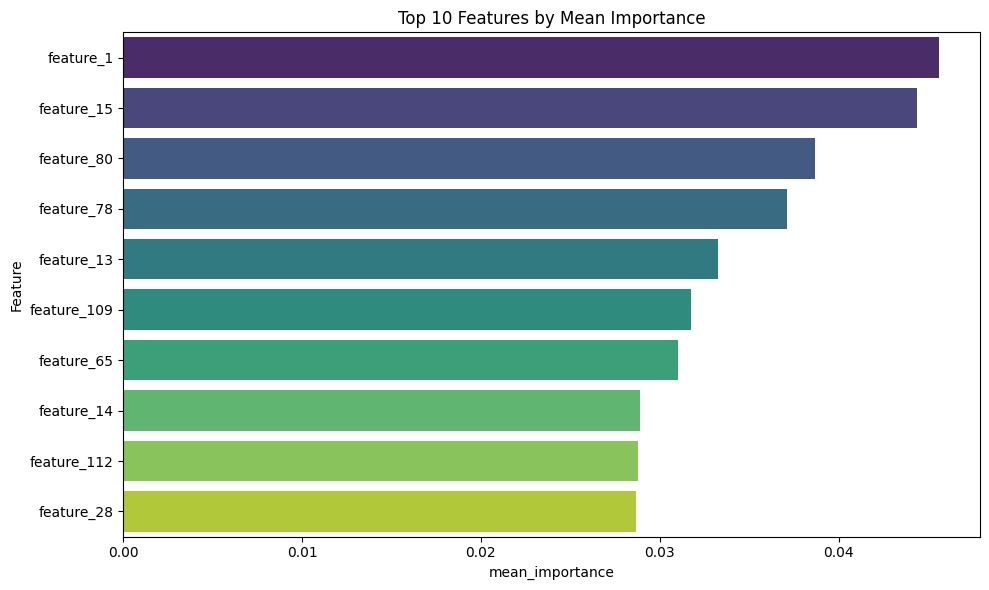

Top 10 features plot saved to /content/drive/MyDrive/kitsune/top_10_features_plot.pdf
Top 10 features data saved to /content/drive/MyDrive/kitsune/top_10_features_data.pdf
No redundant features found.


ImportError: cannot import name 'PDF' from 'IPython.display' (/usr/local/lib/python3.10/dist-packages/IPython/display.py)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import os
from google.colab import drive

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)

# Initial mount
remount_drive()

# Paths
output_path = '/content/drive/MyDrive/kitsune'
combined_csv_path = os.path.join(output_path, 'combined_feature_importances.csv')
top_features_csv_path = os.path.join(output_path, 'top_10_features.csv')
redundant_features_csv_path = os.path.join(output_path, 'redundant_features.csv')

# Load the combined feature importances
feature_importances_df = pd.read_csv(combined_csv_path)

# Calculate mean importance for each feature
feature_stats = feature_importances_df.groupby('Feature').agg(mean_importance=('Importance', 'mean')).reset_index()

# Identify top 10 features
top_features = feature_stats.nlargest(10, 'mean_importance')

# Identify redundant features (features with zero importance)
redundant_features = feature_stats[feature_stats['mean_importance'] == 0]

# Save top 10 features to a CSV file
top_features.to_csv(top_features_csv_path, index=False)
print(f"Top 10 features saved to {top_features_csv_path}")

# Save redundant features to a CSV file
redundant_features.to_csv(redundant_features_csv_path, index=False)
print(f"Redundant features saved to {redundant_features_csv_path}")

# Plot top 10 features and save as a high-resolution PDF
pdf_path_plot = os.path.join(output_path, 'top_10_features_plot.pdf')
with PdfPages(pdf_path_plot) as pdf:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='mean_importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top 10 Features by Mean Importance')
    plt.tight_layout()
    pdf.savefig(bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
print(f"Top 10 features plot saved to {pdf_path_plot}")

# Create a PDF for top 10 features CSV
pdf_path_top_features = os.path.join(output_path, 'top_10_features_data.pdf')
with PdfPages(pdf_path_top_features) as pdf:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=top_features.values, colLabels=top_features.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)
print(f"Top 10 features data saved to {pdf_path_top_features}")

# Create a PDF for redundant features CSV
if not redundant_features.empty:
    pdf_path_redundant_features = os.path.join(output_path, 'redundant_features_data.pdf')
    with PdfPages(pdf_path_redundant_features) as pdf:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=redundant_features.values, colLabels=redundant_features.columns, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
    print(f"Redundant features data saved to {pdf_path_redundant_features}")
else:
    print("No redundant features found.")

# Displaying PDFs inline
from IPython.display import display, PDF

def display_pdf(pdf_path):
    display(PDF(pdf_path))

# Display PDFs
display_pdf(pdf_path_plot)
display_pdf(pdf_path_top_features)
if not redundant_features.empty:
    display_pdf(pdf_path_redundant_features)


In [ ]:
print("Displaying Feature Importances...")
display_images_grid(feature_importances_files, "Feature Importances", os.path.join(output_path, "Feature_Importances_100_estimator_1.0_frac.pdf"))

*Reading File for graphs*

In [ ]:
import os

# Paths to the folders
roc_plots_path = '/content/drive/MyDrive/kitsune/roc_plots'
feature_importances_path = '/content/drive/MyDrive/kitsune/feature_importances'
conf_matrices_path = '/content/drive/MyDrive/kitsune/conf_matrices'

# Function to read all files in a folder
def read_files_in_folder(folder_path):
    files = []
    for root, dirs, filenames in os.walk(folder_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

# Read all files in each folder
roc_plots_files = read_files_in_folder(roc_plots_path)
feature_importances_files = read_files_in_folder(feature_importances_path)
conf_matrices_files = read_files_in_folder(conf_matrices_path)

# Display the files
print("ROC Plots Files:")
for file in roc_plots_files:
    print(file)

print("\nFeature Importances Files:")
for file in feature_importances_files:
    print(file)

print("\nConfusion Matrices Files:")
for file in conf_matrices_files:
    print(file)


ROC Plots Files:
/content/drive/MyDrive/kitsune/roc_plots/all_roc_curves.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.1_30.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.1_50.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.1_100.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.25_30.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.25_50.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.25_100.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.5_30.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.5_50.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.5_100.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.75_30.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_roc_curve_0.75_50.png
/content/drive/MyDrive/kitsune/roc_plots/Video Injection_

# *ROC, Feature Importance & Confusion Matrices Combined Graphs*

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

# Paths to the folders
roc_plots_path = '/content/drive/MyDrive/kitsune/roc_plots'
feature_importances_path = '/content/drive/MyDrive/kitsune/feature_importances'
conf_matrices_path = '/content/drive/MyDrive/kitsune/conf_matrices'

# Function to read all files in a folder
def read_files_in_folder(folder_path):
    files = []
    for root, dirs, filenames in os.walk(folder_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

# Read all files in each folder
roc_plots_files = read_files_in_folder(roc_plots_path)
feature_importances_files = read_files_in_folder(feature_importances_path)
conf_matrices_files = read_files_in_folder(conf_matrices_path)

# Function to display images in a grid and save to PDF
def display_images_grid(image_paths, title, output_pdf):
    num_images = len(image_paths)
    num_cols = 5  # Number of columns
    num_rows = (num_images // num_cols) + int(num_images % num_cols > 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), gridspec_kw={'wspace': 0, 'hspace': 0})
    for ax, img_path in zip(axs.flatten(), image_paths):
        img = imread(img_path)
        ax.imshow(img)
        ax.axis('off')

    for ax in axs.flatten()[len(image_paths):]:
        ax.axis('off')

    plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the title
    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the tight layout to remove extra space
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight', dpi=300)  # Save as high resolution PDF
    plt.show()

# Display and save images in grids
print("Displaying ROC Curves...")
display_images_grid(roc_plots_files, "ROC Curves", "/content/drive/MyDrive/kitsune/ROC_Curves.pdf")

print("Displaying Confusion Matrices...")
display_images_grid(conf_matrices_files, "Confusion Matrices", "/content/drive/MyDrive/kitsune/Confusion_Matrices.pdf")

print("Displaying Feature Importances...")
display_images_grid(feature_importances_files, "Feature Importances", "/content/drive/MyDrive/kitsune/Feature_Importances.pdf")


Output hidden; open in https://colab.research.google.com to view.

# *Consolidating evaluation metrics for each attack type with n_estimator= 100 and fraction = 1.0, as an example for SOK paper*

Displaying ROC Curves...


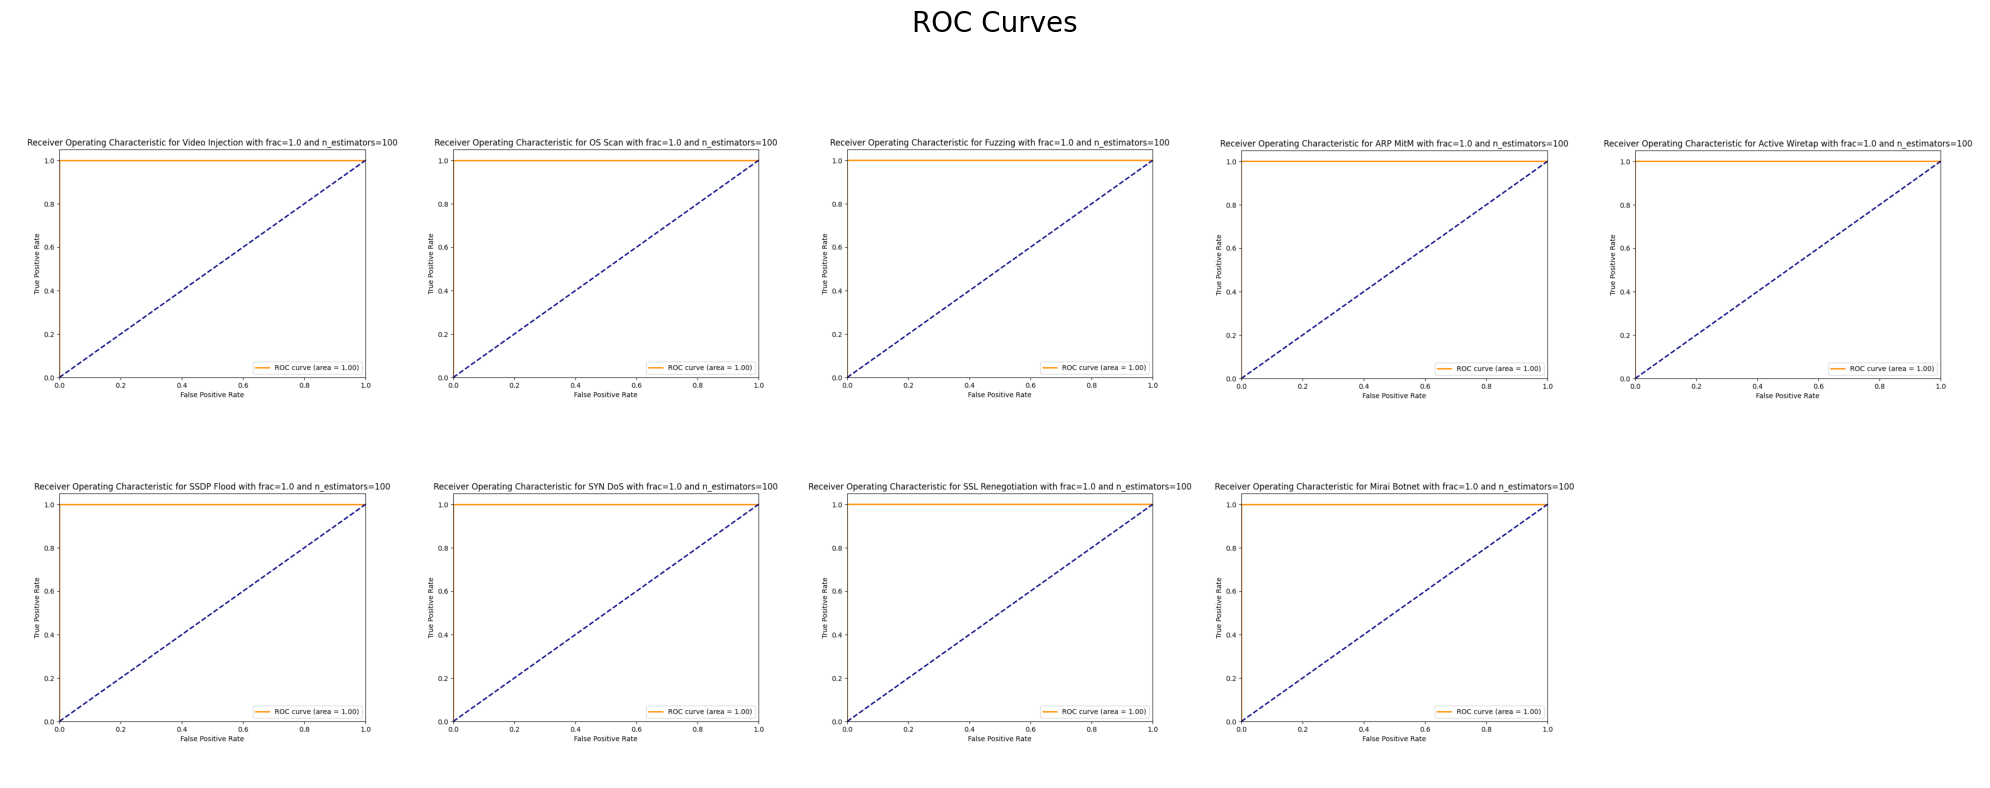

Displaying Confusion Matrices...


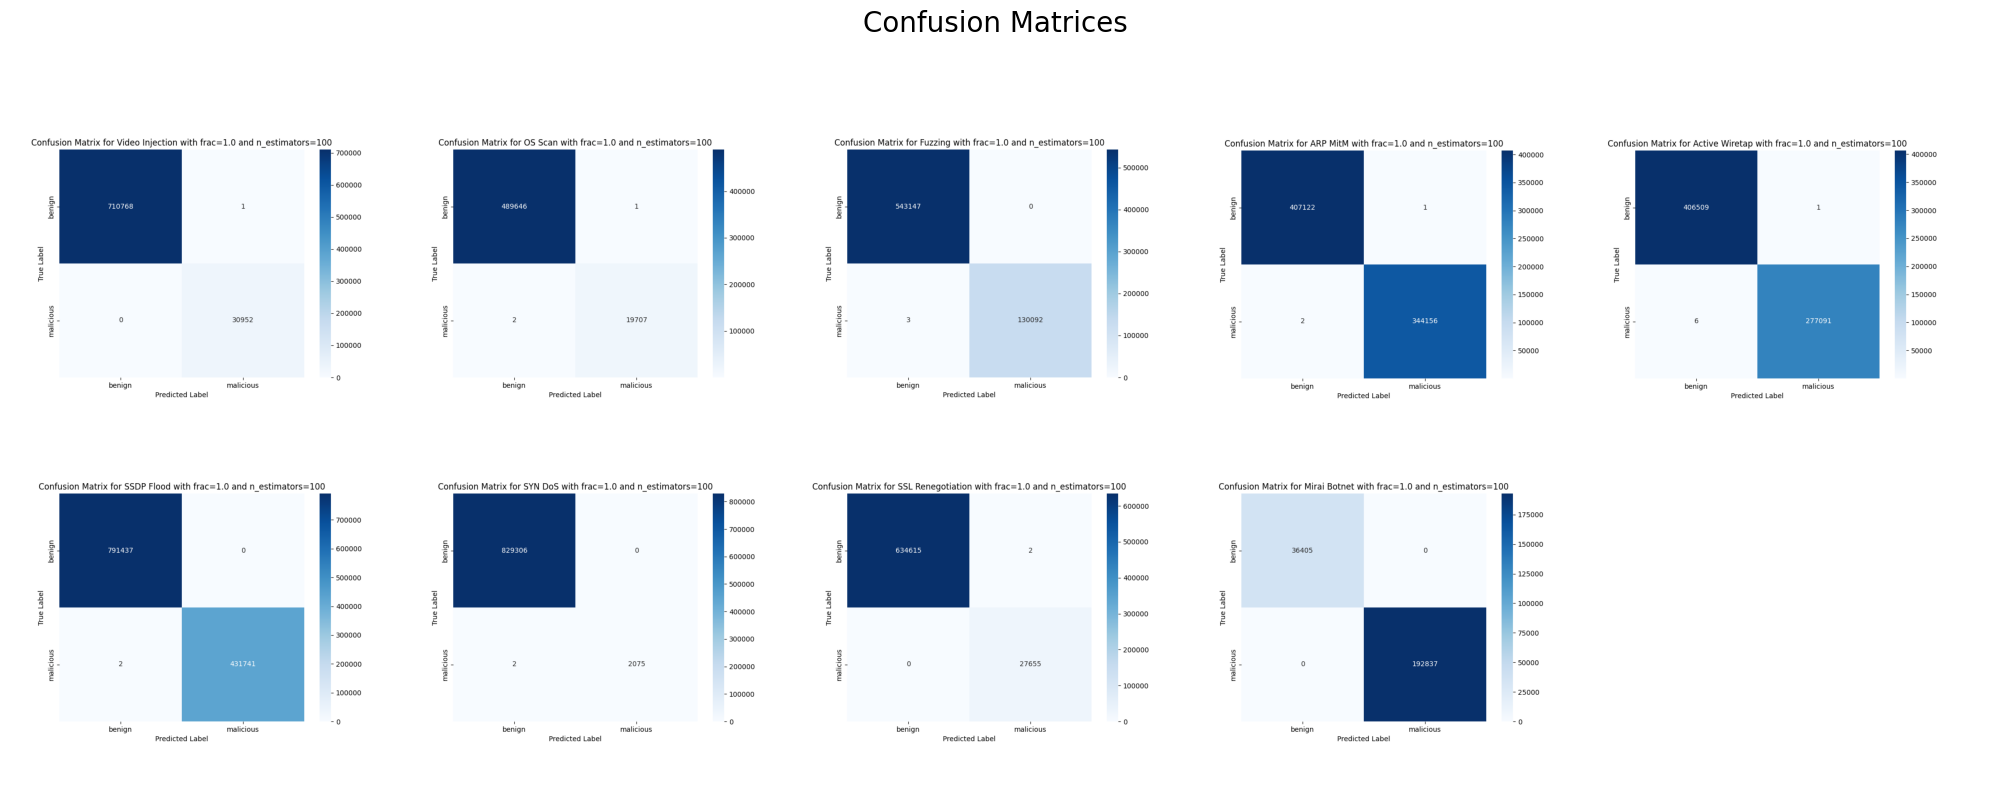

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import pandas as pd

# Paths to the folders
base_path = '/content/drive/MyDrive/kitsune/'
roc_plots_path = os.path.join(base_path, 'roc_plots')
conf_matrices_path = os.path.join(base_path, 'conf_matrices')
#feature_importances_path = os.path.join(base_path, 'feature_importances')
output_path = os.path.join(base_path, 'consolidated_results')

# Function to read all files in a folder
def read_files_in_folder(folder_path, file_pattern):
    files = []
    for root, dirs, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_pattern in filename:
                files.append(os.path.join(root, filename))
    return files

# Function to display images in a grid and save to PDF
def display_images_grid(image_paths, title, output_pdf):
    num_images = len(image_paths)
    num_cols = 5  # Number of columns
    num_rows = (num_images // num_cols) + int(num_images % num_cols > 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), gridspec_kw={'wspace': 0, 'hspace': 0})
    for ax, img_path in zip(axs.flatten(), image_paths):
        img = imread(img_path)
        ax.imshow(img)
        ax.axis('off')

    for ax in axs.flatten()[len(image_paths):]:
        ax.axis('off')

    plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the title
    fig.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the tight layout to remove extra space
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight', dpi=300)  # Save as high-resolution PDF
    plt.show()

# Read all files in each folder with the specified pattern
roc_plots_files = read_files_in_folder(roc_plots_path, '1.0_100')
conf_matrices_files = read_files_in_folder(conf_matrices_path, '1.0_100')


# Display and save images in grids
print("Displaying ROC Curves...")
display_images_grid(roc_plots_files, "ROC Curves", os.path.join(output_path, "ROC_Curves_100_estimator_1.0_frac.pdf"))

print("Displaying Confusion Matrices...")
display_images_grid(conf_matrices_files, "Confusion Matrices", os.path.join(output_path, "Confusion_Matrices_100_estimator_1.0_frac.pdf"))



**Analyze Class Distribution**

Mounted at /content/drive


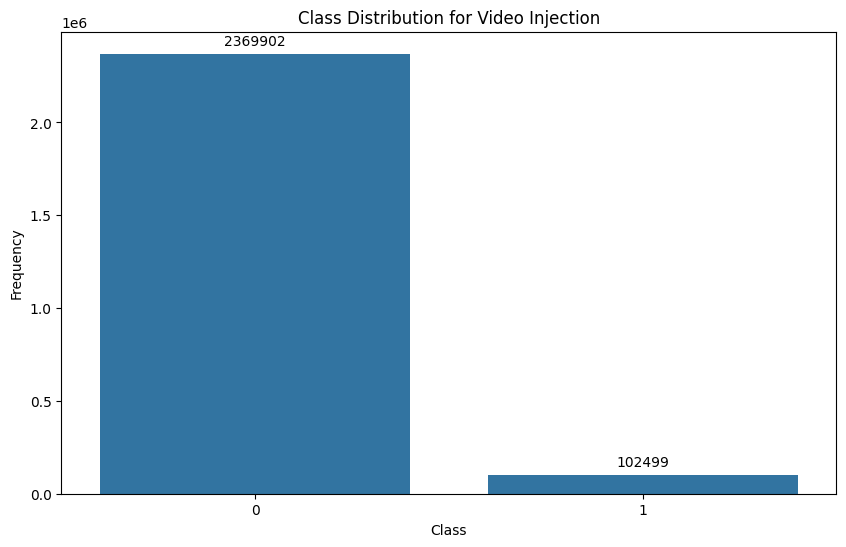

Class Distribution for Video Injection:
label
0    2369902
1     102499
Name: count, dtype: int64



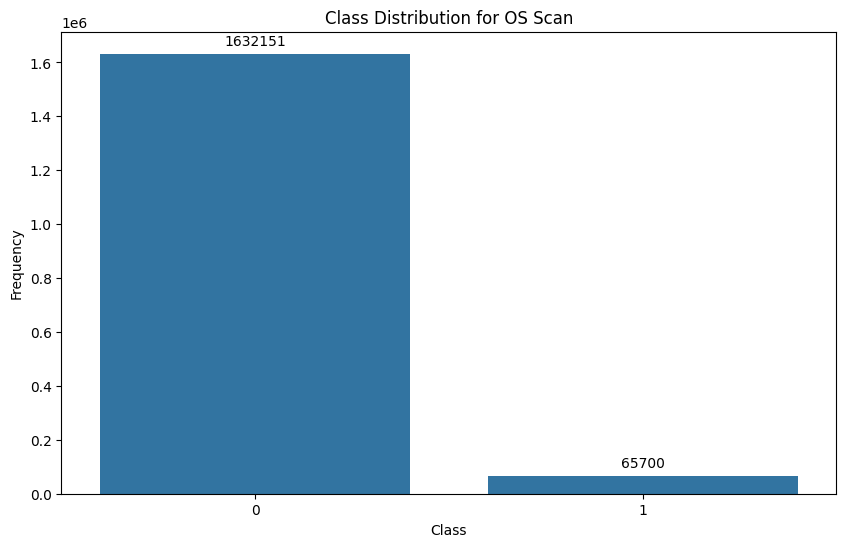

Class Distribution for OS Scan:
label
0    1632151
1      65700
Name: count, dtype: int64



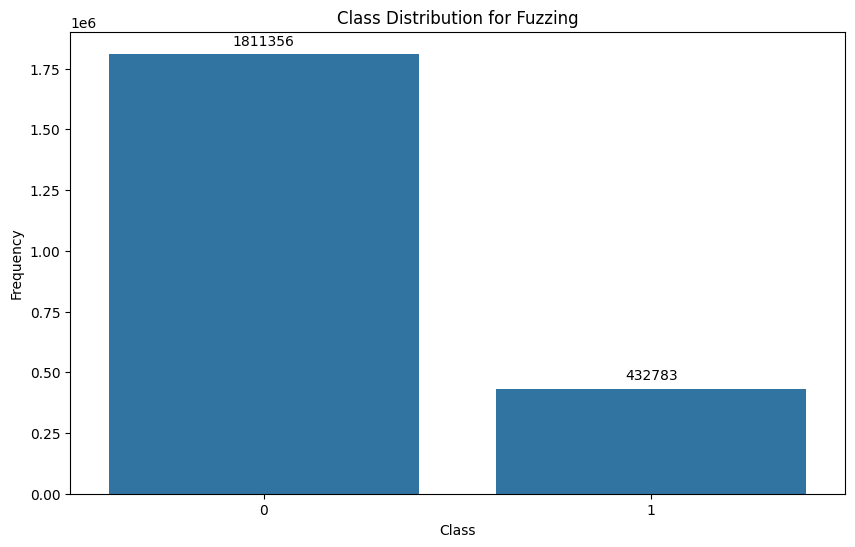

Class Distribution for Fuzzing:
label
0    1811356
1     432783
Name: count, dtype: int64



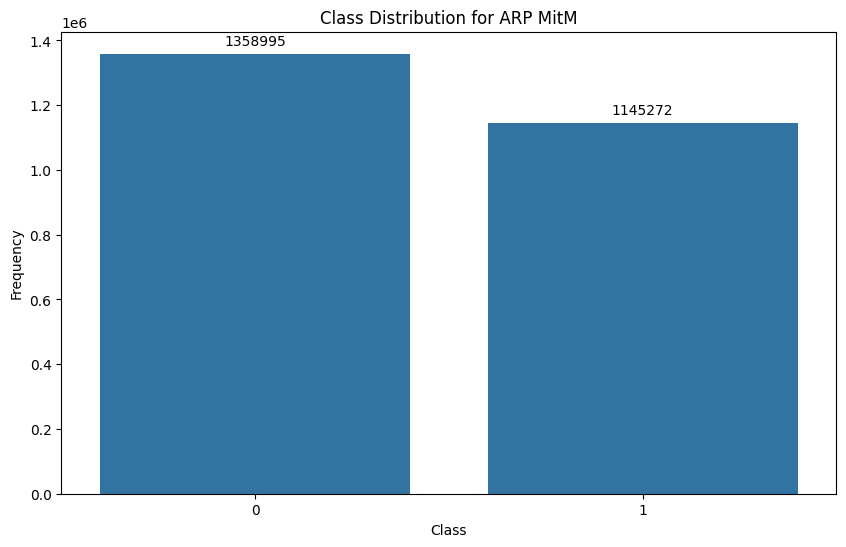

Class Distribution for ARP MitM:
label
0    1358995
1    1145272
Name: count, dtype: int64



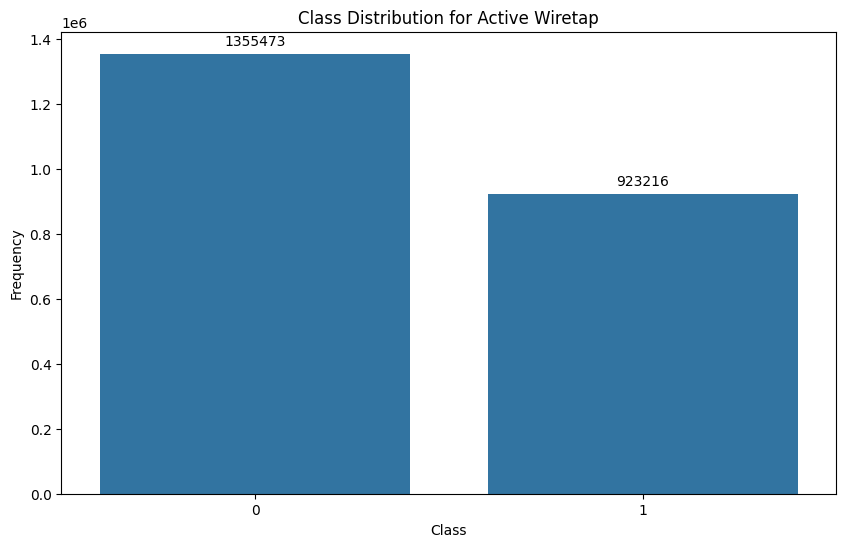

Class Distribution for Active Wiretap:
label
0    1355473
1     923216
Name: count, dtype: int64



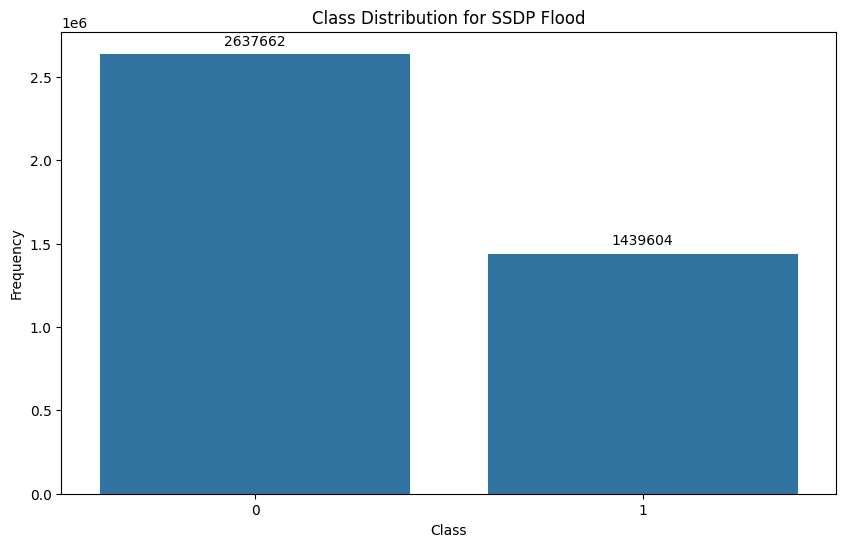

Class Distribution for SSDP Flood:
label
0    2637662
1    1439604
Name: count, dtype: int64



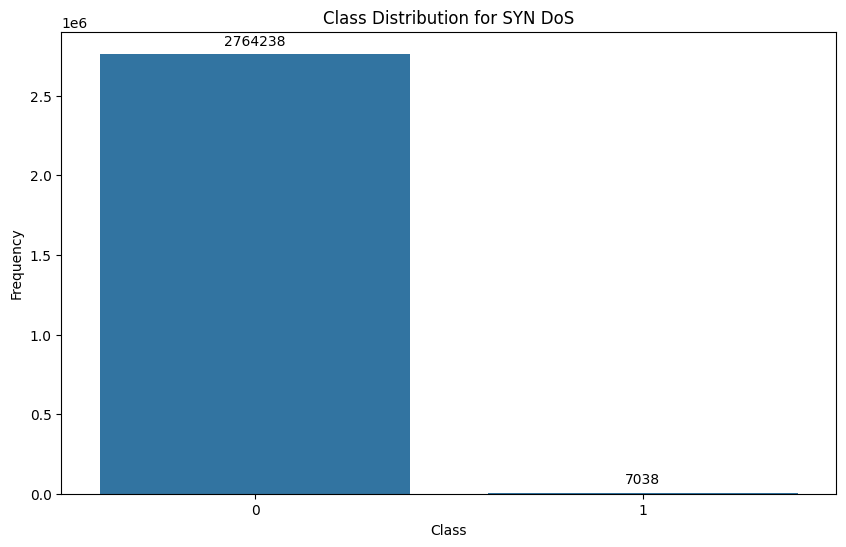

Class Distribution for SYN DoS:
label
0    2764238
1       7038
Name: count, dtype: int64



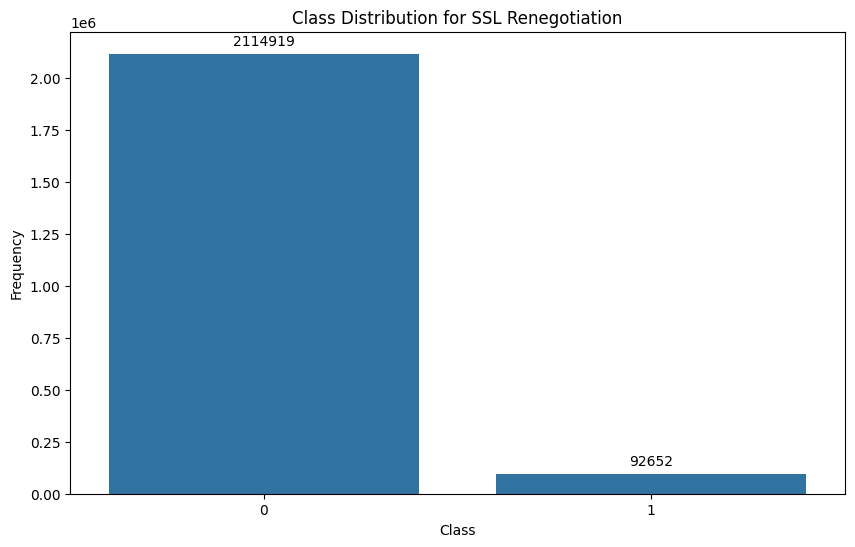

Class Distribution for SSL Renegotiation:
label
0    2114919
1      92652
Name: count, dtype: int64



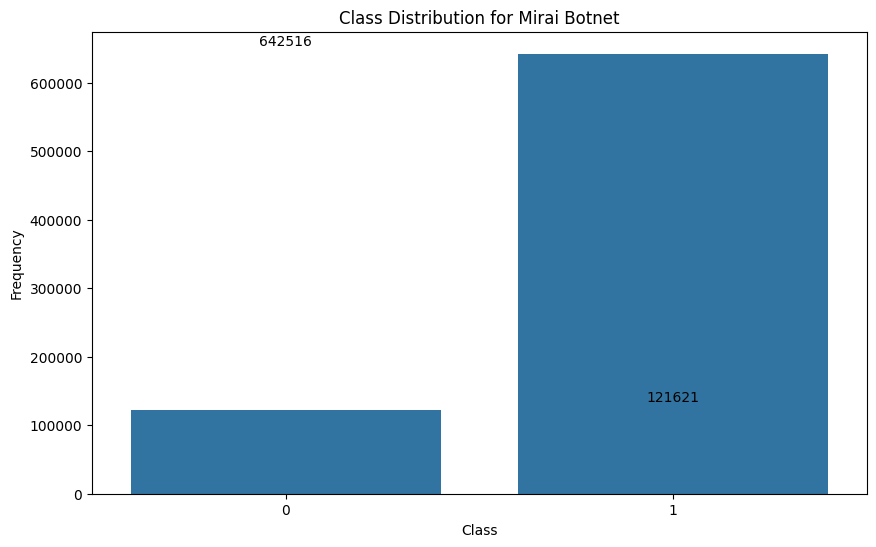

Class Distribution for Mirai Botnet:
label
1    642516
0    121621
Name: count, dtype: int64



In [12]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import time

# Function to remount Google Drive
def remount_drive():
    drive.mount('/content/drive', force_remount=True)
    time.sleep(5)  # Give some time for the drive to mount

# Initial mount
remount_drive()

# Paths
base_path = '/content/drive/MyDrive/kitsune/'
attack_types = ["Video Injection", "OS Scan", "Fuzzing", "ARP MitM", "Active Wiretap",
                "SSDP Flood", "SYN DoS", "SSL Renegotiation", "Mirai Botnet"]

# Function to analyze class distribution
def analyze_class_distribution(attack):
    try:
        labels_path = os.path.join(base_path, attack, f"{attack.replace(' ', '_')}_labels.csv")
        labels = pd.read_csv(labels_path, header=None if attack == "Mirai Botnet" else 0)

        if attack == "Mirai Botnet":
            labels.columns = ["label"]
        else:
            if 'Unnamed: 0' in labels.columns:  # Serial number column
                labels = labels.drop(columns=['Unnamed: 0'])  # Drop the serial number column
            labels.columns = ["label"]  # Rename the remaining column to 'label'

        class_distribution = labels['label'].value_counts()

        # Plot the class distribution
        plt.figure(figsize=(10, 6))
        sns.barplot(x=class_distribution.index, y=class_distribution.values)
        plt.title(f'Class Distribution for {attack}')
        plt.xlabel('Class')
        plt.ylabel('Frequency')

        # Annotate the bars with the counts
        for i in range(len(class_distribution)):
            plt.text(x=i, y=class_distribution.values[i] + 0.02 * class_distribution.values.max(),
                     s=f'{class_distribution.values[i]}', ha='center')

        plt.show()

        # Print the class distribution
        print(f"Class Distribution for {attack}:\n{class_distribution}\n")

    except Exception as e:
        print(f"Error analyzing class distribution for {attack}: {e}")

# Analyze class distribution for each attack type
for attack in attack_types:
    analyze_class_distribution(attack)


The datasets show significant class imbalance, particularly for certain attacks. For example:

Video Injection: 0: 2,369,902, 1: 102,499
SYN DoS: 0: 2,764,238, 1: 7,038
Such imbalances can impact the model's performance, causing it to be biased towards the majority class. To address this, techniques like SMOTE (Synthetic Minority Over-sampling Technique) can be used to balance the datasets

# *** Applying SMOTE to these datasets***